In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [2]:
df17 = pd.read_excel('./data/data2017.xlsx')

In [3]:
df17.columns

Index(['Unnamed: 0', 'district', 'address', 'room_count', 'price',
       'Жилой комплекс', 'Дом', 'Время постройки', 'Этаж', 'Площадь',
       'Состояние', 'Санузел', 'Балкон', 'Балкон остеклен', 'Дверь', 'Телефон',
       'Потолки', 'Безопасноть', 'В прив. общежитии', 'Интернет', 'Мебель',
       'Пол', 'Парковка', 'Latitude', 'Longitude'],
      dtype='object')

In [4]:
df17.head(2)

,Unnamed: 0,district,address,room_count,price,Жилой комплекс,Дом,Время постройки,Этаж,Площадь,...,Телефон,Потолки,Безопасноть,В прив. общежитии,Интернет,Мебель,Пол,Парковка,Latitude,Longitude
0,0,"Алматы, Ауэзовский р-н",мкр №3,3,14 500 000 ₸,-1,панельный,1966 г.п.,1 из 4,60 м2,...,отдельный,-1,-1,нет,проводной,частично меблирована,линолеум,рядом охраняемая стоянка,43.223779,76.849031
1,1,"Алматы, Ауэзовский р-н",мкр №3,3,14 500 000 ₸,-1,панельный,1966 г.п.,1 из 4,60 м2,...,отдельный,-1,-1,нет,проводной,частично меблирована,линолеум,рядом охраняемая стоянка,43.223779,76.849031


In [11]:
df17['Area'] = df17['Площадь'].apply(lambda x: float(x.replace(' м2', '')))

In [20]:
df17['price'] = df17['price'].apply(lambda x: float(x.replace(u'\xa0', u' ').replace('₸', '').replace(' ', '')))

In [33]:
df17.loc[df17['price_per_m2_ln'] == -np.inf] = None

In [21]:
# df17['floor_percent'] = df17['floor']/df17['total_floors'] * 100
df17['price_per_m2'] = df17['price']//df17['Area']
df17['price_per_m2_ln'] = np.log(df17['price_per_m2'])

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
df17.loc[df17['Latitude'].isna()] = None

In [48]:
df17.loc[df17['Longitude'].isna()] = None

In [55]:
df17.loc[df17[['Longitude', 'Latitude']].isna().any(axis=1)] = None

In [73]:
df17['floor'] = df17['Этаж'].apply(lambda x: int(x[:x.find(' ')]) if 'из' in x else int(x))

In [77]:
df17['year_built'] = df17['Время постройки'].apply(lambda x: int(x.replace(' г.п.', '')))

In [260]:
df17['year_old'] = 2017 - df17['year_built']

In [275]:
DecisionTreeRegressor(min_samples_leaf=10).fit(df17[['Latitude', 'Longitude', 'floor', 'year_old']], df17['price_per_m2_ln']).score(df17[['Latitude', 'Longitude', 'floor', 'year_old']], df17['price_per_m2_ln'])

0.682763103048973

In [276]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [121]:
dtree = RandomizedSearchCV(DecisionTreeRegressor(min_samples_leaf=10), {'max_leaf_nodes': range(2000, 10000)})

In [122]:
dtree.fit(df17[['Latitude', 'Longitude', 'floor', 'year_built']], df17['price_per_m2_ln'])

RandomizedSearchCV(estimator=DecisionTreeRegressor(min_samples_leaf=10),
                   param_distributions={'max_leaf_nodes': range(2000, 10000)})

In [123]:
dtree.score(df17[['Latitude', 'Longitude', 'floor', 'year_built']], df17['price_per_m2_ln'])

0.6696891141820038

In [124]:
dtree.best_params_

{'max_leaf_nodes': 2309}

In [229]:
def get_weighted_dist(long: float, lat: float):
    akimat = 10000 * (43.258498, 76.941818)
    stadion = 10000 * (43.238332, 76.923358)
    center_sqare = 10000 * (43.238551, 76.945410)
    long *= 10000
    lat *= 10000
    akimat_dist = ((long - akimat[1]) ** 2 + (lat - akimat[0]) ** 2) ** 0.5
    stadion_dist = ((long - stadion[1]) ** 2 + (lat - stadion[0]) ** 2) ** 0.5
    center_sqare_dist = ((long - center_sqare[1]) ** 2 + (lat - center_sqare[0]) ** 2) ** 0.5
    return (0.3*akimat_dist + 0.4*stadion_dist + 0.3*center_sqare_dist) 

In [210]:
def get_weighted_dist_mall(long: float, lat:float):
    dostyk = 10000 * (43.233486, 76.956623)
    esentai = 10000 * (43.218748, 76.928182)
    mega_rosa = 10000 * (43.202449, 76.891970)
    mega3 = 10000 * (43.264112, 76.929592)
    
    long *= 10000
    lat *= 10000
    dostyk_dist = (abs(long - dostyk[1])  + abs(lat - dostyk[0]))
    esentai_dist = (abs(long - esentai[1])  + abs(lat - esentai[0]))
    mega_rosa_dist = (abs(long - mega_rosa[1]) + abs(lat - mega_rosa[0]))
    mega3_dist = (abs(long - mega3[1]) + abs(lat - mega3[0]))
    
    return min([mega_rosa_dist,esentai_dist,mega3_dist,dostyk_dist])


In [226]:
df17.loc[(df17['Latitude'] > 44) | (df17['Latitude'] < 43) | (df17['Longitude'] < 76.7) | (df17['Longitude'] > 77)] = None

In [264]:
df17['weighted_dist_centers'] = df17[['Longitude', 'Latitude']].apply(lambda row: get_weighted_dist(float(row[0]), float(row[1])), axis=1)

In [265]:
df17['weighted_dist_malls'] = df17[['Longitude', 'Latitude']].apply(lambda row: get_weighted_dist_mall(float(row[0]), float(row[1])), axis=1)

<AxesSubplot: >

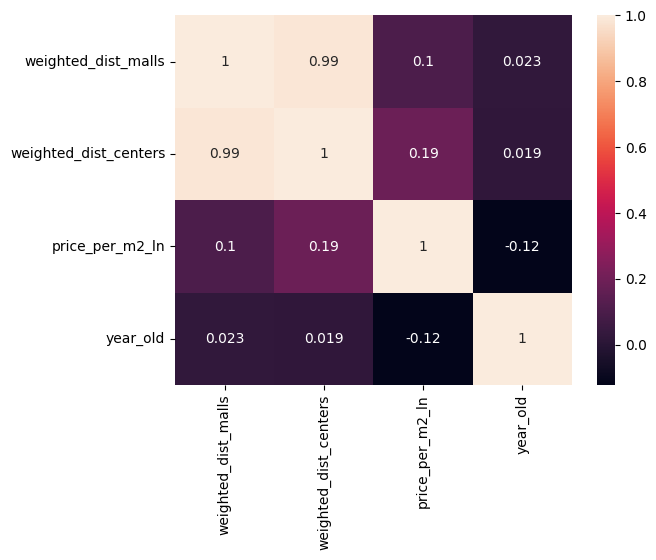

In [266]:
sns.heatmap(df17[['weighted_dist_malls', 'weighted_dist_centers', 'price_per_m2_ln', 'year_old']].corr(), annot=True)

In [ ]:
df17['weighted_dist_malls'] = df17[['Longitude', 'Latitude']].apply(lambda row: get_weighted_dist_mall(float(row[0]), float(row[1])), axis=1)

In [281]:
DecisionTreeRegressor(min_samples_leaf=10).fit(df17[['weighted_dist_kindergarden','weighted_dist_centers','weighted_dist_malls', 'Latitude', 'Longitude', 'floor', 'year_old']], df17['price_per_m2_ln']).score(df17[['weighted_dist_kindergarden','weighted_dist_centers','weighted_dist_malls', 'Latitude', 'Longitude', 'floor', 'year_old']], df17['price_per_m2_ln'])

0.691352498415555

In [285]:
dtree =RandomizedSearchCV(DecisionTreeRegressor(min_samples_leaf=10), {'max_leaf_nodes':range(10, 5000)})

In [291]:
dtree.fit(df17[['weighted_dist_kindergarden','weighted_dist_centers','weighted_dist_malls', 'Latitude', 'Longitude', 'floor', 'year_old']], df17['price_per_m2_ln'])

RandomizedSearchCV(estimator=DecisionTreeRegressor(min_samples_leaf=10),
                   param_distributions={'max_leaf_nodes': range(10, 5000)})

In [292]:
print(dtree.best_params_)
print(dtree.best_score_)

{'max_leaf_nodes': 4252}
0.5285955337382487


In [284]:
kf = KFold(n_splits=10)
x,y = df17[['weighted_dist_kindergarden','weighted_dist_centers','weighted_dist_malls', 'Latitude', 'Longitude', 'floor', 'year_old']], df17['price_per_m2_ln']
kf.get_n_splits(x,y)

scores=[]
for train_index,test_index in kf.split(x, y):    
    X_train1, X_test, y_train1, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    scores.append(DecisionTreeRegressor(min_samples_leaf=10).fit(X_train1, y_train1).score(X_test, y_test))

np.array(scores).mean()

0.5434246287398993

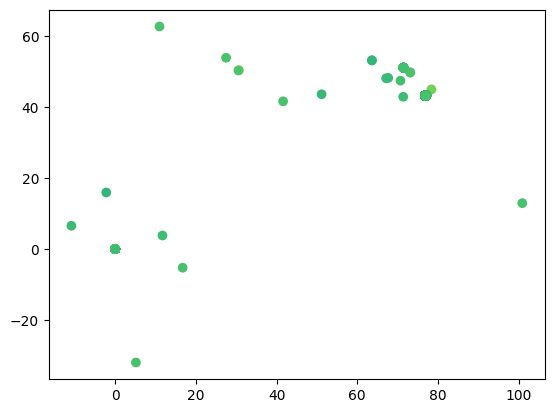

In [218]:
plt.scatter(df17['Longitude'], df17['Latitude'], c=df17['price_per_m2_ln'])

In [234]:
kg = pd.read_excel('./data/Kindergardens Coordianes.xlsx')

In [238]:
kg = kg.drop(columns=['Name']).dropna()

In [268]:
kg['Coordinates_tuples'] = kg['Coordinates '].apply(lambda x: tuple(x.replace('(','').replace(')','').split(', ')))

In [271]:
def get_weighted_dist_kindergarden(long: float, lat:float):
    return min(kg['Coordinates_tuples'].apply(lambda x: abs(float(x[0]) - lat) + abs(float(x[1]) - long)))

In [272]:
df17['weighted_dist_kindergarden'] = df17[['Longitude', 'Latitude']].apply(lambda row: get_weighted_dist_kindergarden(float(row[0]), float(row[1])), axis=1)

<AxesSubplot: >

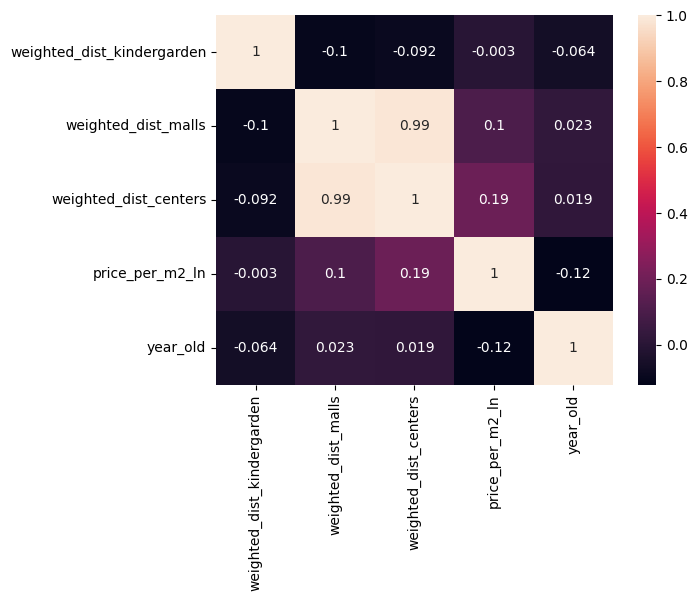

In [273]:
sns.heatmap(df17[['weighted_dist_kindergarden', 'weighted_dist_malls', 'weighted_dist_centers', 'price_per_m2_ln', 'year_old']].corr(), annot=True)

Computed 2017 year

In [ ]:
df19 = pd.read_excel('./data/')

In [244]:
from sklearn.neighbors import KNeighborsRegressor

In [249]:
df17 = df17[['Latitude', 'Longitude', 'floor', 'year_built', 'price_per_m2_ln']].dropna()

In [257]:
knn = KNeighborsRegressor(n_neighbors=1).fit(df17[['Latitude', 'Longitude', 'floor', 'year_built']], df17['price_per_m2_ln'])
knn.score(df17[['Latitude', 'Longitude', 'floor', 'year_built']], df17['price_per_m2_ln'])

0.9476995441382681

In [259]:
kf = KFold(n_splits=10)
x,y =df17[['Latitude', 'Longitude', 'floor', 'year_built']], df17['price_per_m2_ln']
kf.get_n_splits(x,y)

scores=[]
for train_index,test_index in kf.split(x, y):    
    X_train1, X_test, y_train1, y_test = x.iloc[train_index], x.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    scores.append(KNeighborsRegressor(n_neighbors=1).fit(X_train1, y_train1).score(X_test, y_test))

np.array(scores).mean()

KeyError: 'price_per_m2'

In [ ]:
dtree = GridSearchCV(DecisionTreeRegressor(min_samples_leaf=10), {'max_leaf_nodes':range(2,500)}, cv=10)
